# Laboratorium 2 - otoczka wypukła

# Autor: Tomasz Boroń

#### Narzędzie graficzne

In [41]:
# Narzędzie jest oparte o kilka zewnętrznych bibliotek, które potrzebujemy najpierw zaimportować.
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
import json as js

# Parametr określający jak blisko (w odsetku całego widocznego zakresu) punktu początkowego 
# wielokąta musimy kliknąć, aby go zamknąć.
TOLERANCE = 0.15

def dist(point1, point2):
    return np.sqrt(np.power(point1[0] - point2[0], 2) + np.power(point1[1] - point2[1], 2))

# Klasa ta trzyma obecny stan wykresu oraz posiada metody, które mają zostać wykonane
# po naciśnięciu przycisków.
class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = []
        self.adding_lines = False
        self.added_lines = []
        self.adding_rects = False
        self.added_rects = []

    def set_axes(self, ax):
        self.ax = ax
        
    # Metoda ta obsługuje logikę przejścia do następnej sceny.
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw(autoscaling = True)

    # Metoda ta obsługuje logikę powrotu do poprzedniej sceny.
    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw(autoscaling = True)
        
    # Metoda ta aktywuje funkcję rysowania punktów wyłączając równocześnie rysowanie 
    # odcinków i wielokątów.
    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.adding_lines = False
            self.adding_rects = False
            self.added_points.append(PointsCollection([]))
            
    # Metoda ta aktywuje funkcję rysowania odcinków wyłączając równocześnie
    # rysowanie punktów i wielokątów.     
    def add_line(self, event):   
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.adding_rects = False
            self.added_lines.append(LinesCollection([]))

    # Metoda ta aktywuje funkcję rysowania wielokątów wyłączając równocześnie
    # rysowanie punktów i odcinków.
    def add_rect(self, event):
        self.adding_rects = not self.adding_rects
        self.new_line_point = None
        if self.adding_rects:
            self.adding_points = False
            self.adding_lines = False
            self.new_rect()
    
    def new_rect(self):
        self.added_rects.append(LinesCollection([]))
        self.rect_points = []
        
    # Metoda odpowiedzialna za właściwą logikę rysowania nowych elementów. W
    # zależności od włączonego trybu dodaje nowe punkty, początek, koniec odcinka
    # lub poszczególne wierzchołki wielokąta. Istnieje ciekawa logika sprawdzania
    # czy dany punkt jest domykający dla danego wielokąta. Polega ona na tym, że
    # sprawdzamy czy odległość nowego punktu od początkowego jest większa od
    # średniej długości zakresu pomnożonej razy parametr TOLERANCE.   
    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (event.xdata, event.ydata)
        if self.adding_points:
            self.added_points[-1].add_points([new_point])
            self.draw(autoscaling = False)
        elif self.adding_lines:
            if self.new_line_point is not None:
                self.added_lines[-1].add([self.new_line_point, new_point])
                self.new_line_point = None
                self.draw(autoscaling = False)
            else:
                self.new_line_point = new_point
        elif self.adding_rects:
            if len(self.rect_points) == 0:
                self.rect_points.append(new_point)
            elif len(self.rect_points) == 1:
                self.added_rects[-1].add([self.rect_points[-1], new_point])
                self.rect_points.append(new_point)
                self.draw(autoscaling = False)
            elif len(self.rect_points) > 1:
                if dist(self.rect_points[0], new_point) < (np.mean([self.ax.get_xlim(), self.ax.get_ylim()])*TOLERANCE):
                    self.added_rects[-1].add([self.rect_points[-1], self.rect_points[0]])
                    self.new_rect()
                else:    
                    self.added_rects[-1].add([self.rect_points[-1], new_point])
                    self.rect_points.append(new_point)
                self.draw(autoscaling = False)
    
    # Metoda odpowiedzialna za narysowanie całego wykresu. Warto zauważyć,
    # że zaczyna się ona od wyczyszczenia jego wcześniejszego stanu. Istnieje w
    # niej nietrywialna logika zarządzania zakresem wykresu, tak żeby, w zależności
    # od ustawionego parametru autoscaling, uniknąć sytuacji, kiedy dodawanie
    # nowych punktów przy brzegu obecnie widzianego zakresu powoduje niekorzystne
    # przeskalowanie.
    def draw(self, autoscaling = True):
        if not autoscaling:
            xlim = self.ax.get_xlim()
            ylim = self.ax.get_ylim()
        self.ax.clear()
        for collection in (self.scenes[self.i].points + self.added_points):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (self.scenes[self.i].lines + self.added_lines + self.added_rects):
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale(autoscaling)
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
        plt.draw()

#### Interfejsy

In [42]:
# Klasa Scene odpowiada za przechowywanie elementów, które mają być
# wyświetlane równocześnie. Konkretnie jest to lista PointsCollection i
# LinesCollection.
class Scene:
    def __init__(self, points=[], lines=[]):
        self.points=points
        self.lines=lines

# Klasa PointsCollection gromadzi w sobie punkty jednego typu, a więc takie,
# które zostaną narysowane w takim samym kolorze i stylu. W konstruktorze
# przyjmuje listę punktów rozumianych jako pary współrzędnych (x, y). Parametr
# kwargs jest przekazywany do wywołania funkcji z biblioteki MatPlotLib przez
# co użytkownik może podawać wszystkie parametry tam zaproponowane.        
class PointsCollection:
    def __init__(self, points, **kwargs):
        self.points = points
        self.kwargs = kwargs
    
    def add_points(self, points):
        self.points = self.points + points

# Klasa LinesCollection podobnie jak jej punktowy odpowiednik gromadzi
# odcinki tego samego typu. Tworząc ją należy podać listę linii, gdzie każda
# z nich jest dwuelementową listą punktów – par (x, y). Parametr kwargs jest
# przekazywany do wywołania funkcji z biblioteki MatPlotLib przez co użytkownik
# może podawać wszystkie parametry tam zaproponowane.
class LinesCollection:
    def __init__(self, lines, **kwargs):
        self.lines = lines
        self.kwargs = kwargs
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)

# Klasa Plot jest najważniejszą klasą w całym programie, ponieważ agreguje
# wszystkie przygotowane sceny, odpowiada za stworzenie wykresu i przechowuje
# referencje na przyciski, dzięki czemu nie będą one skasowane podczas tzw.
# garbage collectingu.
class Plot:
    def __init__(self, scenes = [Scene()], points = [], lines = [], json = None):
        if json is None:
            self.scenes = scenes
            if points or lines:
                self.scenes[0].points = points
                self.scenes[0].lines = lines
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]
    
    # Ta metoda ma szczególne znaczenie, ponieważ konfiguruje przyciski i
    # wykonuje tym samym dość skomplikowaną logikę. Zauważmy, że konfigurując każdy
    # przycisk podajemy referencję na metodę obiektu _Button_callback, która
    # zostanie wykonana w momencie naciśnięcia.
    def __configure_buttons(self):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_point = plt.axes([0.44, 0.05, 0.15, 0.075])
        ax_add_line = plt.axes([0.28, 0.05, 0.15, 0.075])
        ax_add_rect = plt.axes([0.12, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Następny')
        b_next.on_clicked(self.callback.next)
        b_prev = Button(ax_prev, 'Poprzedni')
        b_prev.on_clicked(self.callback.prev)
        b_add_point = Button(ax_add_point, 'Dodaj punkt')
        b_add_point.on_clicked(self.callback.add_point)
        b_add_line = Button(ax_add_line, 'Dodaj linię')
        b_add_line.on_clicked(self.callback.add_line)
        b_add_rect = Button(ax_add_rect, 'Dodaj figurę')
        b_add_rect.on_clicked(self.callback.add_rect)
        return [b_prev, b_next, b_add_point, b_add_line, b_add_rect]
    
    def add_scene(self, scene):
        self.scenes.append(scene)
    
    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes

    # Metoda toJson() odpowiada za zapisanie stanu obiektu do ciągu znaków w
    # formacie JSON.
    def toJson(self):
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])    
    
    # Metoda ta zwraca punkty dodane w trakcie rysowania.
    def get_added_points(self):
        if self.callback:
            return self.callback.added_points
        else:
            return None
    
    # Metoda ta zwraca odcinki dodane w trakcie rysowania.
    def get_added_lines(self):
        if self.callback:
            return self.callback.added_lines
        else:
            return None
        
    # Metoda ta zwraca wielokąty dodane w trakcie rysowania.
    def get_added_figure(self):
        if self.callback:
            return self.callback.added_rects
        else:
            return None
    
    # Metoda ta zwraca punkty, odcinki i wielokąty dodane w trakcie rysowania
    # jako scenę.
    def get_added_elements(self):
        if self.callback:
            return Scene(self.callback.added_points, self.callback.added_lines+self.callback.added_rects)
        else:
            return None
    
    # Główna metoda inicjalizująca wyświetlanie wykresu.
    def draw(self):
        plt.close()
        fig = plt.figure()
        self.callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons()
        ax = plt.axes(autoscale_on = False)
        self.callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        self.callback.draw()

#### Przykład rysunku dynamicznego

<IPython.core.display.Javascript object>


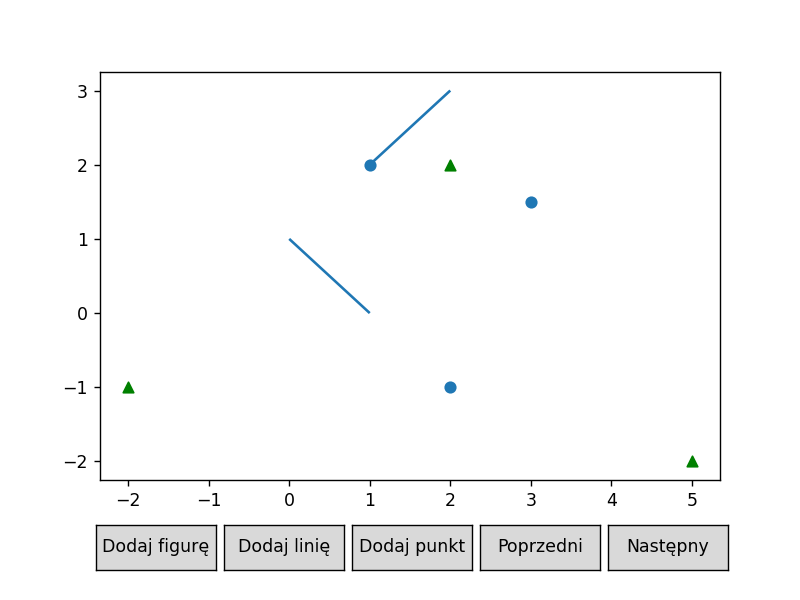

In [43]:
%matplotlib notebook

scenes=[Scene([PointsCollection([(1, 2), (3, 1.5), (2, -1)]), 
               PointsCollection([(5, -2), (2, 2), (-2, -1)], color='green', marker = "^")], 
              [LinesCollection([[(1,2),(2,3)], [(0,1),(1,0)]])]), 
        Scene([PointsCollection([(1, 2), (3, 1.5), (2, -1)], color='red'), 
               PointsCollection([(5, -2), (2, 2), (-2, 1)], color='black')], 
              [LinesCollection([[(-1,2),(-2,3)], [(0,-1),(-1,0)]])])]

plot=Plot(scenes = scenes)
plot.draw() 

#### Generacja zadanych ustalonych zbiorów punktów

###### Punkty losowo wybrane z prostokąta 200x200

<IPython.core.display.Javascript object>


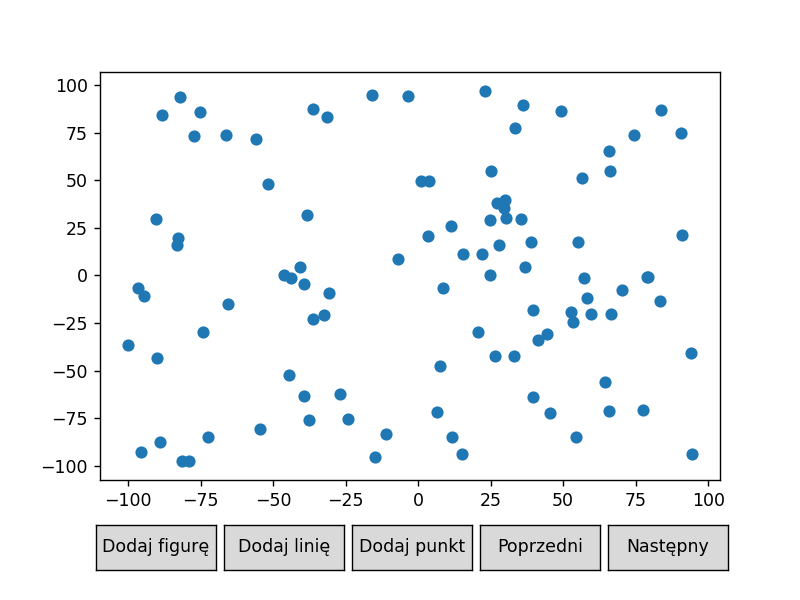

In [105]:
from random import random

p1=[]
for i in range(100):
    p1.append( (random()*200-100 , random()*200-100) )
plot1=Plot(points=[PointsCollection(p1)])
plot1.draw() 

###### Punkty leżące na okręgu o środku (0, 0) i promieniu R=10

<IPython.core.display.Javascript object>


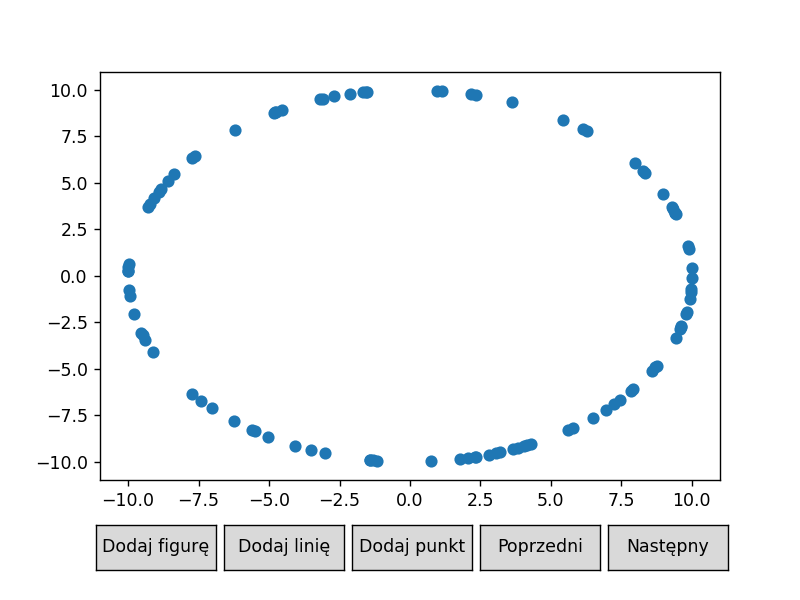

In [106]:
from math import sin,cos,pi

p2=[]
R=10
for i in range(100):
    angle=random()*2*pi
    p2.append( (R*cos(angle), R*sin(angle)) )
plot2=Plot(points=[PointsCollection(p2)])
plot2.draw() 

###### Punkty leżące na bokach prostokąta o podanych wierzchołkach (w punktach o współrzędnych (+-10, +-10))

<IPython.core.display.Javascript object>


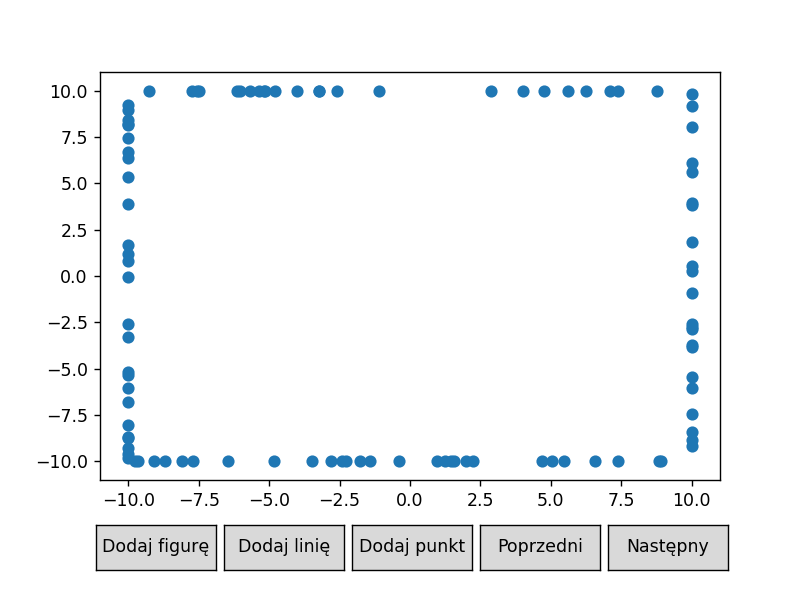

In [107]:
from random import randint

p3=[]
for i in range(100):
    x=randint(1,4)
    if x==1:
        p3.append((random()*20-10,10))
    elif x==2:
        p3.append((10,random()*20-10))
    elif x==3:
        p3.append((random()*20-10,-10))
    else:
        p3.append((-10,random()*20-10))
plot3=Plot(points=[PointsCollection(p3)])
plot3.draw() 

###### Punkty leżące w wierzchołkach, na bokach oraz przekątnych kwadratu

<IPython.core.display.Javascript object>


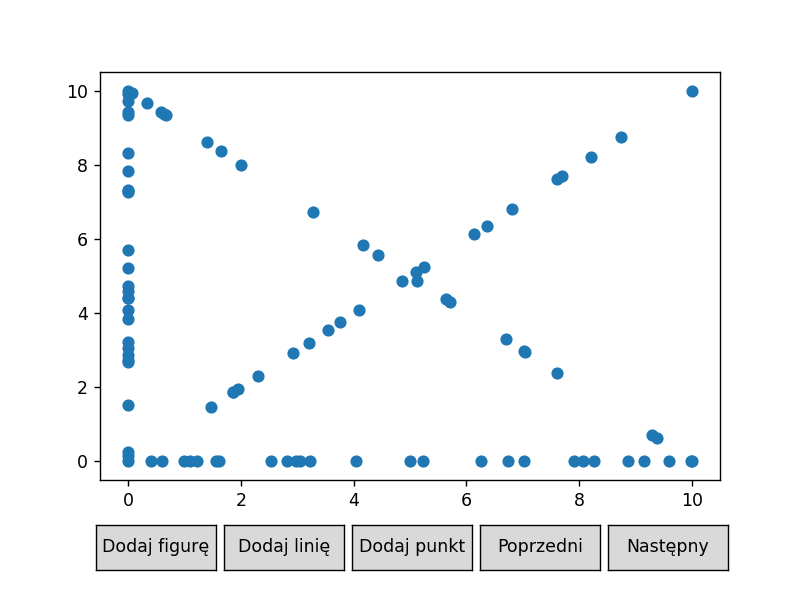

In [108]:
p4=[(0,0),(0,10),(10,10),(10,0)]
for i in range(25):
    p4.append((0,random()*10))
    p4.append((random()*10,0))
for i in range(20):
    s=random()
    t=random()
    p4.append((10*s,10*s))
    p4.append((10*t,10-10*t))
plot4=Plot(points=[PointsCollection(p4)])
plot4.draw() 

#### Modyfikacje dot. wprowadzania własnych parametrów do generacji zbiorów

###### Losowe punkty z podanych przedziałów

<IPython.core.display.Javascript object>


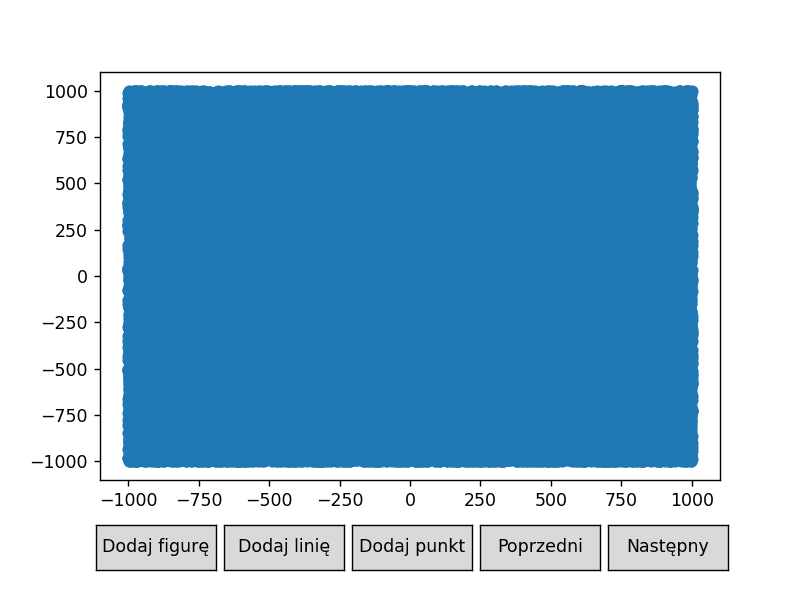

In [109]:
p1_p=[]
def rand1(amount,x0,x1,y0,y1):
    for i in range(amount):
        p1_p.append(( random()*(x1-x0)+x0 , random()*(y1-y0)+y0 ))
    plot1p=Plot(points=[PointsCollection(p1_p)])
    plot1p.draw()

rand1(100000,-1000,1000,-1000,1000)

###### Punkty na okręgu o podanym środku i promieniu

<IPython.core.display.Javascript object>


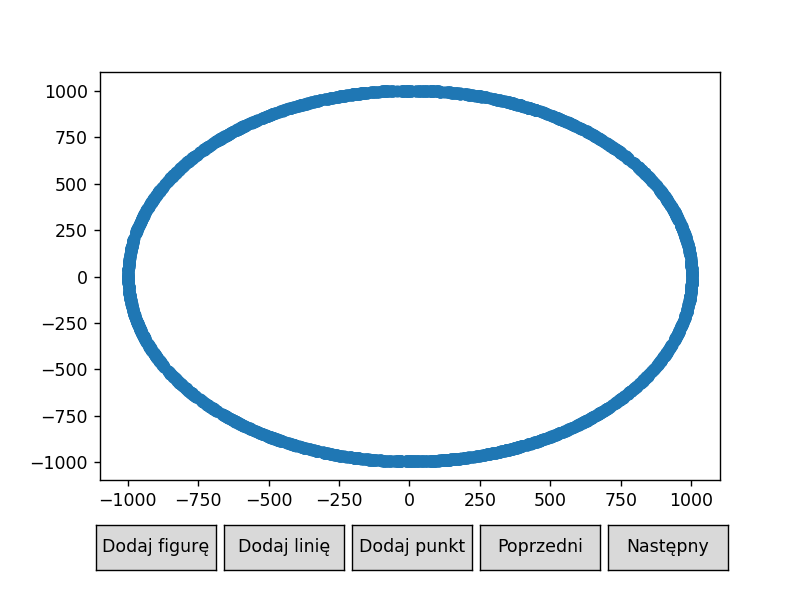

In [110]:
p2_p=[]
def rand2(amount,x0,y0,R):
    for i in range(amount):
        angle=random()*2*pi
        p2_p.append((x0+R*cos(angle),y0+R*sin(angle)))
    plot2p=Plot(points=[PointsCollection(p2_p)])
    plot2p.draw()

rand2(2000,2,3,1000)

###### Punkty na bokach prostokąta o podanych wierzchołkach

<IPython.core.display.Javascript object>


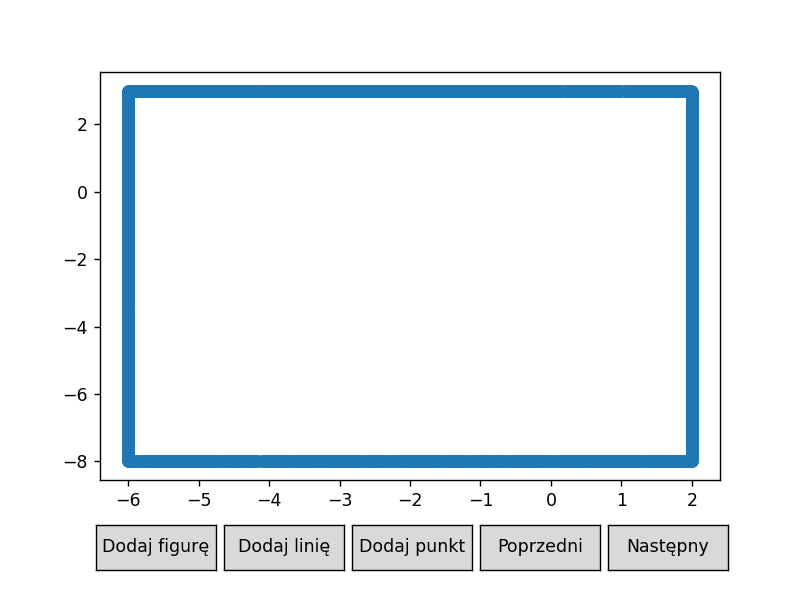

In [111]:
p3_p=[]
def rand3(amount,point1,point2,point3,point4): # od lewego górnego zgodnie z ruchem wskazówek zegara
    for i in range(amount):
        x=randint(1,4)
        if x==1:
            p3_p.append((random()*(point2[0]-point1[0])+point1[0],point1[1])) # górny bok
        elif x==2:
            p3_p.append((point2[0],random()*(point2[1]-point3[1])+point3[1])) # prawy bok
        elif x==3:
            p3_p.append((random()*(point3[0]-point4[0])+point4[0],point3[1])) # dolny bok
        else:
            p3_p.append((point4[0],random()*(point1[1]-point4[1])+point4[1])) # lewy bok
    plot3p=Plot(points=[PointsCollection(p3_p)])
    plot3p.draw()

rand3(5000,(-6,3),(2,3),(2,-8),(-6,-8))

###### Punkty generowane dla kwadratu o podanych wierzchołkach, ilości punktów na osiach i przekątnych 

<IPython.core.display.Javascript object>


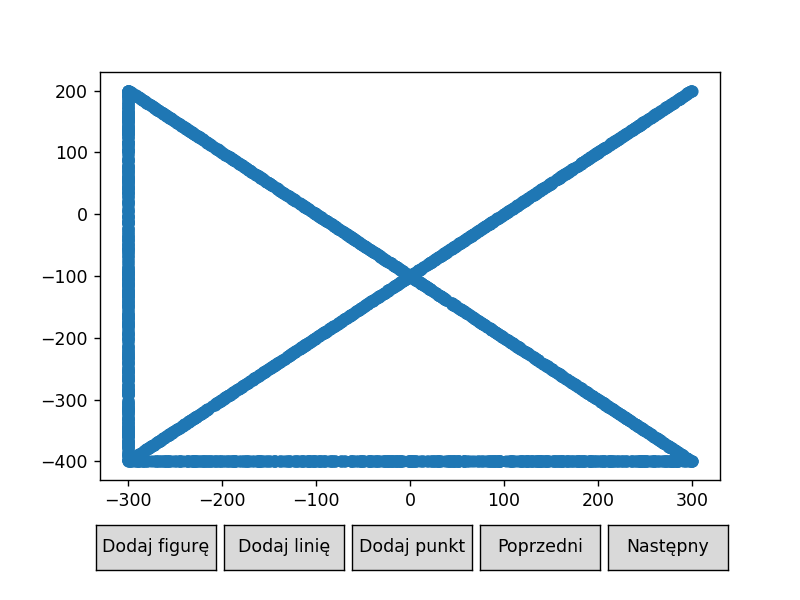

In [112]:
p4_p=[] 
def rand4(amount_axle,amount_diag,point1,point2,point3,point4):
    p4_p.append(point1)
    p4_p.append(point2)
    p4_p.append(point3)
    p4_p.append(point4)
    for i in range(amount_axle):
        p4_p.append((point4[0],random()*(point1[1]-point4[1])+point4[1]))
        p4_p.append((random()*(point3[0]-point4[0])+point4[0],point4[1]))
    for i in range(amount_diag):
        s=random()
        t=random()
        x1=(point2[0]-point4[0])*s+point4[0]
        y1=(point2[1]-point4[1])*s+point4[1]
        x2=(point1[0]-point3[0])*t+point3[0]
        y2=(point1[1]-point3[1])*t+point3[1]
        p4_p.append((x1,y1))
        p4_p.append((x2,y2))    
    plot4p=Plot(points=[PointsCollection(p4_p)])
    plot4p.draw()

rand4(500,1000,(-300,200),(300,200),(300,-400),(-300,-400))

## Zapis do pliku

In [54]:
def saveFile(pset, name):
    file = open(name+".txt","w") 
    for i in pset: 
        file.write(str(i)+'\n')
    file.close()

## Implementacja algorytmu Grahama i Jarvisa

#### Przygotowanie odpowiednich funkcji pomocniczych

###### Dokładność 0

In [55]:
eps=10**(-10)

###### Wyznacznik, 3x3 implementowany samodzielnie

In [56]:
def orient(a, b, c):
    return a[0] * b[1] + a[1] * c[0] + b[0] * c[1] - c[0] * b[1] - c[1] * a[0] - b[0] * a[1]

###### Iloczyn skalarny

In [57]:
def scalar(a,b,c):
    return (b[0]-a[0])*(c[0]-a[0])+(b[1]-a[1])*(c[1]-a[1])

###### Długość wektora

In [58]:
from math import sqrt

def vectorLen(a,b):
    return sqrt((b[0]-a[0])**2+(b[1]-a[1])**2)

###### Sortowanie punktów po współrzędnej kątowej

In [59]:
def sortpoints(p, p0, start, end):
    pivot = p[end]
    i = start - 1
    for j in range(start, end):
        if orient(p0, pivot, p[j]) < -eps:
            i += 1
            p[i], p[j] = p[j], p[i]
    p[i + 1], p[end] = p[end], p[i + 1]
    if start<i: sortpoints(p, p0, start, i)
    if i+2<end: sortpoints(p, p0, i + 2, end)

###### Usuwanie współliniowych

In [60]:
def delColinear(p):
    i=1
    while i<len(p)-1:
        if orient(p[0],p[i],p[i+1])>=-eps and orient(p[0],p[i],p[i+1])<=eps:
            if vectorLen(p[0],p[i])>vectorLen(p[0],p[i+1]):
                p.pop(i+1)
            else: p.pop(i)
        else:
            i+=1

## Algorytm Grahama

In [20]:
# STARA WERSJA UŻYWAJĄCA STOSU
# zostawiona awaryjnie, bo sprawdzona
# nowa wersja niżej ze stosem na tablicy, ponieważ dało to możliwość ładniejszej wizualizacji


#from queue import LifoQueue
#
#scenes=[]
#
#def Graham(p):
#    scenes.clear()
#    pcopy=[]
#    pcopy.extend(p)
#    scenes.append(Scene([PointsCollection(p,color="blue")]))
#    stack = LifoQueue()
#    pcopy.sort(key=lambda x: x[0])
#    pcopy.sort(key=lambda x: x[1])
#    sortpoints(pcopy, pcopy[0],1,len(pcopy)-1)
#    scenes.append(Scene([PointsCollection(p,color="blue"),
#                         PointsCollection([pcopy[0]],color="red"),
#                         PointsCollection([pcopy[1]],color="green")
#                       ]))
#    delColinear(pcopy)
#    scenes.append(Scene([PointsCollection(pcopy,color="blue")
#                       ]))
#    lines=[]
#    stack.put(pcopy[0])
#    stack.put(pcopy[1])
#    stack.put(pcopy[2])
#    i = 3
#    while i < len(pcopy):
#        p2 = stack.get()
#        p1 = stack.get()
#        stack.put(p1)
#        stack.put(p2)
#        if orient(p1, p2, pcopy[i]) > eps:
#            stack.put(pcopy[i])
#            i += 1
#        else:
#            stack.get()
#    hull = []
#    while not stack.empty():
#        hull.append(stack.get())
#    hull.reverse()
#    for i in range(len(hull)):
#        lines.append([hull[i%len(hull)],hull[(i+1)%len(hull)]])
#        scenes.append(Scene([PointsCollection(p,color="lime"),
#                         PointsCollection(hull,color="red")],
#                        [LinesCollection(lines[0:i])
#                       ]))
#    scenes.append(Scene([PointsCollection(p,color="lime"),
#                        PointsCollection(hull,color="red")],
#                        [LinesCollection(lines)
#                       ]))
#    print(hull)

###### Wersja z wizualizacją

In [61]:
scenes=[]

def Graham(p,save):
    scenes.clear()
    pcopy=[]
    pcopy.extend(p)
    scenes.append(Scene([PointsCollection(p,color="blue")]))
    stack = []
    pcopy.sort(key=lambda x: x[0])
    pcopy.sort(key=lambda x: x[1])
    sortpoints(pcopy, pcopy[0],1,len(pcopy)-1)  # sortowanie po współrzędnej kątowej
    scenes.append(Scene([PointsCollection(p,color="blue"),
                         PointsCollection([pcopy[0]],color="red"),
                         PointsCollection([pcopy[1]],color="green")
                       ]))
    delColinear(pcopy)  # usuwanie współliniowych
    scenes.append(Scene([PointsCollection(pcopy,color="blue") # dodatkowa wizualizacja pokazująca bez współliniowych (z p0)
                       ]))
    stack.append(pcopy[0])
    stack.append(pcopy[1])
    stack.append(pcopy[2])
    lines=[(stack[x],stack[x+1]) for x in range(len(stack)-1)]
    scenes.append(Scene([PointsCollection(p)],
                        [LinesCollection(lines[0:len(lines)],color="red")
                       ]))
    i = 3
    while i < len(pcopy):
        p2 = stack.pop(-1)
        p1 = stack.pop(-1)
        stack.append(p1)
        stack.append(p2)
        lines=[(stack[x],stack[x+1]) for x in range(len(stack)-1)]
        scenes.append(Scene([PointsCollection(p)],
                            [LinesCollection(lines[0:len(lines)],color="red"),
                             LinesCollection([(stack[len(stack)-2],stack[len(stack)-1])],color="blue"),
                             LinesCollection([(stack[len(stack)-1],pcopy[i])],color="green")
                       ]))
        if orient(p1, p2, pcopy[i]) > eps:
            stack.append(pcopy[i])
            i += 1
        else:
            stack.pop(-1)
    hull = []
    while not len(stack)==0:
        hull.append(stack.pop(-1))
    hull.reverse()
    for i in range(len(hull)):
        lines.append([hull[i%len(hull)],hull[(i+1)%len(hull)]])
        scenes.append(Scene([PointsCollection(p,color="lime"),
                         PointsCollection(hull,color="red")],
                        [LinesCollection(lines[0:i])
                       ]))
    scenes.append(Scene([PointsCollection(p,color="lime"),
                        PointsCollection(hull,color="red")],
                        [LinesCollection(lines)
                       ]))
    if save:
        saveFile(hull,"GrahamResult")
    #print(hull) #usunąć komentarz w celu wypisania punktów poniżej w programie
    #return hull

###### Wersja do pomiaru czasu

In [62]:
def Graham_To_Measure_Time(p,save):
    pcopy=[]
    pcopy.extend(p)
    stack = []
    pcopy.sort(key=lambda x: x[0])
    pcopy.sort(key=lambda x: x[1])
    sortpoints(pcopy, pcopy[0],1,len(pcopy)-1)  # sortowanie po współrzędnej kątowej
    delColinear(pcopy)  # usuwanie współliniowych
    stack.append(pcopy[0])
    stack.append(pcopy[1])
    stack.append(pcopy[2])
    i = 3
    while i < len(pcopy):
        p2 = stack.pop(-1)
        p1 = stack.pop(-1)
        stack.append(p1)
        stack.append(p2)
        if orient(p1, p2, pcopy[i]) > eps:
            stack.append(pcopy[i])
            i += 1
        else:
            stack.pop(-1)
    hull = []
    while not len(stack)==0:
        hull.append(stack.pop(-1))
    if save:
        saveFile(hull,"GrahamResult")
    #print(hull) #usunąć komentarz w celu wypisania punktów poniżej w programie
    #return hull

## Algorytm Jarvisa

###### Wersja do wizualizacji

In [63]:
from math import inf

scenesj=[]

def Jarvis(p,save):
    scenesj.clear()
    pcopy=[]
    pcopy.extend(p)
    scenesj.append(Scene([PointsCollection(p,color="blue")]))
    hull = []
    pcopy.sort(key=lambda x: x[0])
    pcopy.sort(key=lambda x: x[1])
    scenesj.append(Scene([PointsCollection(p,color="blue"),
                         PointsCollection([pcopy[0]],color="red")
                       ]))
    linesj=[]
    hull.append(pcopy[0])
    i0 = pcopy[0]
    prev=i0
    i=(prev[0]+eps,prev[1]) # pierwszy wektor od którego liczę kąt
    while not i == i0:
        long=(2*i[0]-prev[0],2*i[1]-prev[1])  
        if len(hull)>2 and orient(hull[-3],hull[-2],hull[-1])>=-eps and orient(hull[-3],hull[-2],hull[-1])<=eps:
            hull.pop(-2)  # zdejmowanie współliniowych
        kval = -1         # początkowe wartości aby znaleźć punkt - dlaczego takie, opisane w sprawozdaniu wstęp teoretyczny
        kpoint = (inf, inf)
        for j in pcopy:
            if not j == i and not j == prev:
                currentvalue=scalar(i,long,j)/(vectorLen(i,long)*vectorLen(i,j)) # z definicji cosinusa kąta oraz iniekcji na przedziale [0,pi]
                if currentvalue>kval:  # korzystam z faktu że cosinus maleje w [0,pi] więc największy jest dla najmniejszego kąta
                    kval = currentvalue
                    kpoint = j
        hull.append(kpoint)
        prev = i
        i = kpoint
    for n in range(len(hull)):
        linesj.append([hull[n%len(hull)],hull[(n+1)%len(hull)]])
        scenesj.append(Scene([PointsCollection(p,color="lime"),
                         PointsCollection(hull,color="red")],
                        [LinesCollection(linesj[0:n])
                       ]))
    scenesj.append(Scene([PointsCollection(p,color="lime"),
                        PointsCollection(hull,color="red")],
                        [LinesCollection(linesj)
                       ]))
    if save:
        saveFile(hull,"JarvisResult")
    #print(hull) #usunąć komentarz w celu wypisania punktów poniżej w programie
    #return hull

###### Wersja do pomiaru czasu

In [64]:
from math import inf

def Jarvis_To_Measure_Time(p,save):
    pcopy=[]
    pcopy.extend(p)
    hull = []
    pcopy.sort(key=lambda x: x[0])
    pcopy.sort(key=lambda x: x[1])
    hull.append(pcopy[0])
    i0 = pcopy[0]
    prev=i0
    i=(prev[0]+eps,prev[1]) # pierwszy wektor od którego liczę kąt
    while not i == i0:
        long=(2*i[0]-prev[0],2*i[1]-prev[1])  
        if len(hull)>2 and orient(hull[-3],hull[-2],hull[-1])>=-eps and orient(hull[-3],hull[-2],hull[-1])<=eps:
            hull.pop(-2)  # zdejmowanie współliniowych
        kval = -1         # początkowe wartości aby znaleźć punkt - dlaczego takie, opisane w sprawozdaniu wstęp teoretyczny
        kpoint = (inf, inf)
        for j in pcopy:
            if not j == i and not j == prev:
                currentvalue=scalar(i,long,j)/(vectorLen(i,long)*vectorLen(i,j)) # z definicji cosinusa kąta oraz iniekcji na przedziale [0,pi]
                if currentvalue>kval:  # korzystam z faktu że cosinus maleje w [0,pi] więc największy jest dla najmniejszego kąta
                    kval = currentvalue
                    kpoint = j
        hull.append(kpoint)
        prev = i
        i = kpoint
    if save:
        saveFile(hull,"JarvisResult")
    #print(hull) #usunąć komentarz w celu wypisania punktów poniżej w programie
    #return hull

###### Test działania

###### Słownik zbiorów

p1 - losowe 100 punktów z wnętrza prostokąta
p2 - okrąg o środku (0,0) i promieniu R=10, 100 punktów
p3 - 100 punktów leżących na bokach prostokąta [-10,10] x [-10,10]
p4 - Zbiór zawierający wierzchołki kwadratu (0, 0), (10, 0), (10, 10), (0, 10) oraz punkty wygenerowane losowo w sposób   następujący: po 25 punktów na dwóch bokach kwadratu leżących na osiach i po 20 punktów na przekątnych kwadratu.

[któraś z powyższych nazw]_p - zbiór z parametrami ustalonymi przy generacji

###### Algorytmy w wersji do wizualizacji

<IPython.core.display.Javascript object>


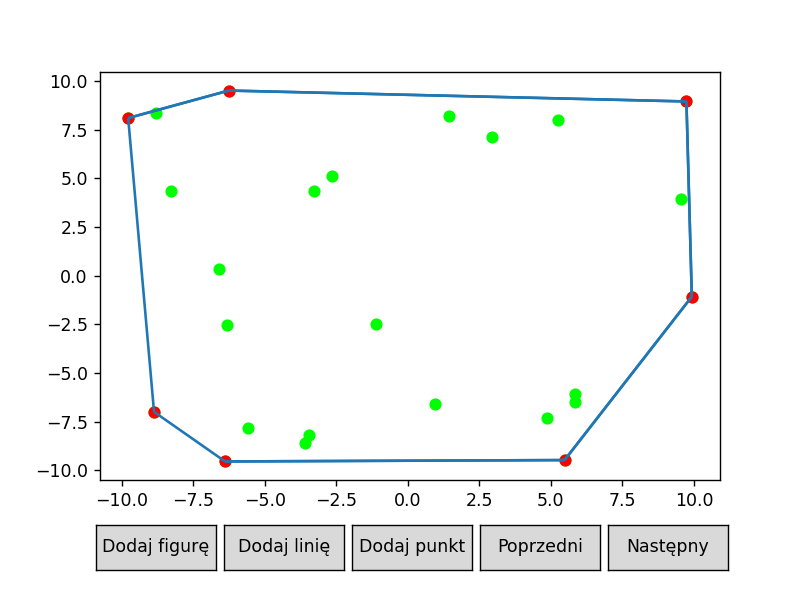

In [23]:
Graham(p1_p,False) # True jeśli chcemy zapisać wynik w pliku, False w p. p.
plotg=Plot(scenes = scenes)
plotg.draw() 

<IPython.core.display.Javascript object>


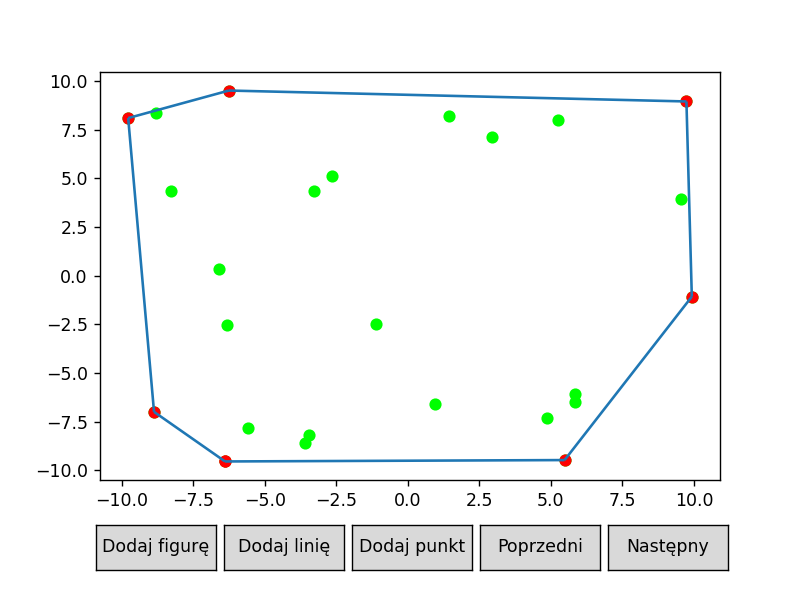

In [24]:
Jarvis(p1_p,False)
plotj=Plot(scenes=scenesj)
plotj.draw()

###### Algorytmy w wersji do pomiaru czasu

In [127]:
from time import time
startg=time()
Graham_To_Measure_Time(p4_p,False) # True jeśli chcemy zapisać wynik w pliku, False w p. p.
endg=time()
print("Czas działania algorytmu: ",endg-startg," sekund")

Czas działania algorytmu:  1.1874914169311523  sekund


In [128]:
startj=time()
Jarvis_To_Measure_Time(p4_p,False)
endj=time()
print("Czas działania algorytmu: ",endj-startj," sekund")

Czas działania algorytmu:  3.2022266387939453  sekund
